### Modelling and Forecasting Brent Crude Oil with Random Forest Regressor

1. Importing Libraries: The first step is to import the necessary libraries. These libraries provide the tools and functions needed to perform the tasks in the code.

- `sklearn.model_selection.RandomizedSearchCV`:
  This is a function for performing randomized search on hyperparameters. It is used to find the best parameters for the model.
- `sklearn.metrics.mean_absolute_error`, `mean_absolute_percentage_error`, `mean_squared_error`:
  These are functions for calculating different types of error metrics between the actual and predicted values.
- `sklearn.ensemble.RandomForestRegressor`:
  This is the Random Forest regression model from the sklearn library.
- `numpy`:
  This is a library for numerical computations in Python.
- `plotly.graph_objects` and `plotly.express`:
  These are libraries for creating interactive plots.
- `pandas`: This is a library for data manipulation and analysis.


In [1]:
#%%
# Importing libraries
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import plotly.offline as py
# py.init_notebook_mode()

2. **Loading Data**:
   The data is loaded from a CSV file into a pandas DataFrame.

- The parse_dates=True argument is used to automatically parse dates in the CSV file, and `index_col=[0]` sets the first (0th) column as the index of the DataFrame.


In [2]:
#%%
# Importing data
data = pd.read_csv('Modified_Data.csv', parse_dates=True, index_col=[0])

3. **Visualize Data**: Plot the data with price on the y axis and dates on the x axis


<Axes: >

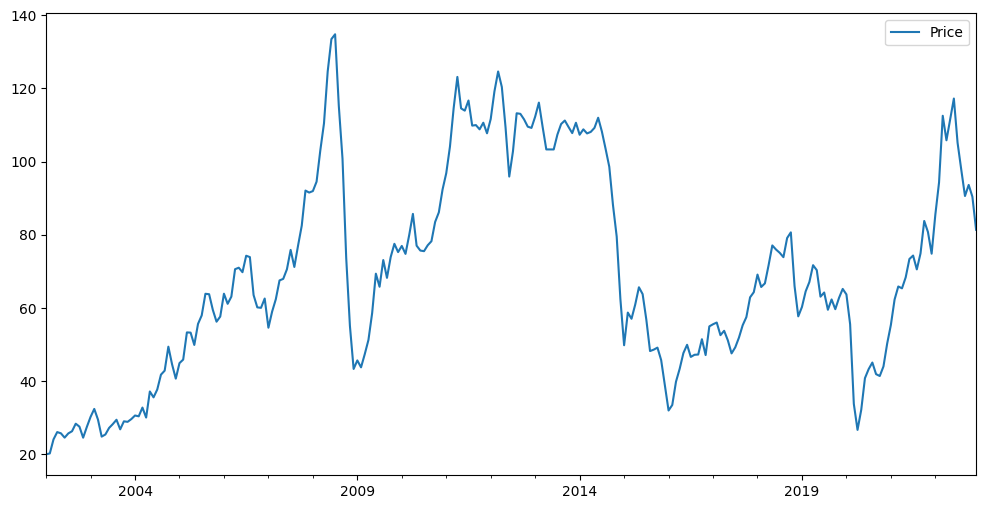

In [3]:
# px.line(data, x=data.index, y='Price', title='Prices of Brent Crude Oil from 2002 to 2022')

# plot with matplotlib
data.plot(figsize=(12,6))

4. **Setting Train and Test Dates**:
   The start dates for the training and test datasets are defined.


In [4]:
#%%
# Set dates for training and testing
train_start_date = '2002-01-01'
test_start_date = '2019-01-01'

5. **Creating Train and Test Datasets**: The data is split into training and test datasets based on the defined start dates.

- The training dataset includes all data from the start date to the day before the test start date.
- The test dataset includes all data from the test start date onwards.


In [5]:
#%%

# set the train and test data and print the dimensions of it
train = data.copy()[(data.index >= train_start_date) & (data.index < test_start_date)][['Price']]
test = data.copy()[data.index >= test_start_date][['Price']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (204, 1)
Test data shape:  (48, 1)


6. **Visualize Training and Testing Sets**: Plot the train and testing sets on a graph


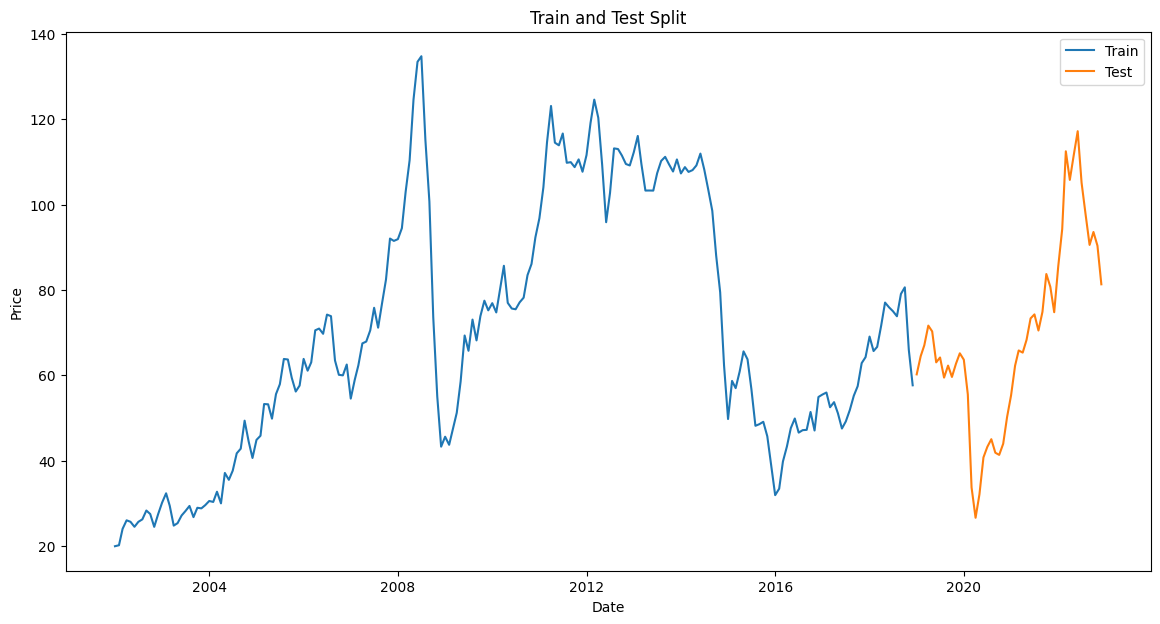

In [6]:
# Plot train and test splits
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=train.index, y=train['Price'], mode='lines', name='Train'))
# fig.add_trace(go.Scatter(x=test.index, y=test['Price'], mode='lines', name='Test'))
# fig.update_layout(title='Train and Test Split', xaxis_title='Date', yaxis_title='Price')
# fig.show()


import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Price'], label='Train')
plt.plot(test.index, test['Price'], label='Test')
plt.title('Train and Test Split')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()



7. **Creating Timesteps**: The data is reshaped into a 3D array where the third dimension represents the timesteps. This is done for both the training and test datasets.

- The concept of "timesteps" is used to define the number of time periods to look back in the data to make a prediction. This is also known as the "lag".
- For example, if you're predicting monthly sales and you set timesteps to 12, the model will use the sales of the previous 12 months to predict the sales of the next month.


In [7]:
#%%

# Set the timesteps
timesteps = 24

# Convert the data to numpy array
train_data = train.values
test_data = test.values

# Create timesteps for the train data
train_data_timesteps = np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]

# Create timesteps for the test data
test_data_timesteps = np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]


8. **Splitting Data into Features and Target**: The data is split into features (X) and target (y) for both the training and test datasets. The target is the last timestep and the features are all the other timesteps.


In [8]:
# Split the data into features and target
X_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]

X_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

#to avoid the warning
y_train = y_train.ravel()
y_test = y_test.ravel()

<details>
<summary>Overview of Random Forests</summary>

### Understanding Random Forest Regression for Time Series Forecasting.

Imagine you're lost in a vast forest (the Random Forest) trying to predict your way out (future oil prices). You wouldn't rely solely on one person's guess, right? That's the power of Random Forest Regression! It builds a team of experts (decision trees) by asking them simple questions about the past (like recent price changes). Here's how it works, explained step-by-step with a helpful flowchart (see below):

**1. Gathering Clues: Bootstrap Sampling**

The journey begins by collecting clues (data samples) with a little twist. We don't pick just once; we allow some samples to appear multiple times, like revisiting a familiar landmark . This creates multiple sets of clues for the experts to analyze.

**2. Consulting the Experts: Decision Tree Building**

Now, it's time to meet the experts – the decision trees. Each expert receives a unique set of clues (from the bootstrap sampling) and starts building a map (decision tree) out of the forest.

**3. Asking Smart Questions**

But the experts don't have access to everything. At each point in their exploration (decision point), they only consider a random subset of features (like price changes in the past week) . This helps them focus on the most relevant clues and avoid getting overwhelmed.

**4. Choosing the Best Guide: Feature Selection**

Based on the chosen subset, each expert asks a specific question. For example, "Did the price go up significantly last week?". The question that best separates the data into groups with similar future prices wins! This chosen feature becomes the guide for splitting the path on their map (decision tree).

**5. Building the Knowledge: Tree by Tree**

By continuously asking these focused questions and splitting the data, each expert builds a detailed decision tree. This tree represents their understanding of how past events (features) might influence future prices.

**6. Combining the Wisdom: Averaging Predictions**

Once all the experts have built their maps, it's time to combine their knowledge. We don't pick a single map; instead, we take an average prediction from all the trees. This way, we leverage the insights from every expert, leading to a more robust prediction for future oil prices.

</details>
<br>
<details>
<summary>Visualizing the Journey: The Flowchart</summary>

### Visualizing the Journey: The Flowchart\*\*

```mermaid
graph TD
    A[Start: Random Forest Regression]
     --> B[Bootstrap Sampling]
    B --> C[Decision Tree Building]
    C --> D1[Consider Random Subset of Features e.g., recent price changes]
    D1 --> E1[Choose Best Feature for Split]
    E1 --> F1[Build Decision Tree]
    C --> D2[Consider Random Subset of Features e.g., recent price changes]
    D2 --> E2[Choose Best Feature for Split]
    E2 --> F2[Build Decision Tree]
    C --> D3[Consider Random Subset of Features e.g., recent price changes]
    D3 --> E3[Choose Best Feature for Split]
    E3 --> F3[Build Decision Tree]
    F1 --> G[Average Predictions]
    F2 --> G
    F3 --> G
    G --> H[End: Final Prediction]
```

</details>


9. **Setting Up the Model**: A Random Forest Regressor model is set up and a RandomizedSearchCV is used to find the best parameters for the model.

**How the parameters in `param_dist_rf work`**

1. `n_estimators`: The number of trees in the forest. More trees reduce the variance of predictions, improving the model's performance. However, too many trees can slow down the model without providing much benefit.

2. `max_depth`: The maximum depth of the trees. Deeper trees can model more complex patterns, but they're also more likely to overfit to the training data.

3. `max_features`: The number of features to consider when looking for the best split. Considering more features at each split can increase the model's flexibility, but it can also slow down the training process.

4. `min_samples_split`: The minimum number of samples required to split an internal node. Larger values can help prevent overfitting, but if they're too large, the model might underfit.

5. `bootstrap`: Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.


In [9]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Define the hyperparameters for the RandomizedSearchCV
param_dist_rf = {"n_estimators": np.random.randint(450, 500, size=10), # Number of trees in random forest
                 "max_depth": np.append(np.random.randint(1, 5, size=5), None), # Maximum depth of the tree 
                 "max_features": np.random.randint(1, 11, size=10), # Number of features to consider at every split
                 "min_samples_split": np.random.randint(2, 11, size=10), # Minimum number of samples required to split a node
                 "bootstrap": [True, False]} # Method of selecting samples for training each tree

rf = RandomForestRegressor(random_state=42) # Instantiate the model

tscv = TimeSeriesSplit(n_splits=5) # Instantiate TimeSeriesSplit

random_search_rf = RandomizedSearchCV(rf, param_distributions=param_dist_rf,
                                      n_iter=10, cv=tscv, random_state=42) # Instantiate the RandomizedSearchCV


10. **Training the Model**: The model is trained on the training data.


In [10]:
#%%
# Fit the model
random_search_rf.fit(X_train, y_train)
best_rf = random_search_rf.best_estimator_
# Predict the test data
best_rf.fit(train_data_timesteps[:,:timesteps-1], train_data_timesteps[:,[timesteps-1]])

d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor(max_depth=4, max_features=10, min_samples_split=10,
                      n_estimators=470, random_state=42)

11. **Making Predictions**: The model is used to make predictions on the test data with the best parameters


In [11]:
#%%
# Predict the test data
rf_predictions = best_rf.predict(test_data_timesteps[:,:timesteps-1])

12. **Evaluating the Model**: The model's predictions are compared to the actual values to calculate the

- root mean squared error (RMSE)
- mean absolute error (MAE), and
- mean absolute percentage error (MAPE).


In [12]:
#%%
# Calculate the evaluation metrics
mse_rf = mean_squared_error(test_data_timesteps[:,[timesteps-1]], rf_predictions)
rmse_rf = np.sqrt(mean_squared_error(test_data_timesteps[:,[timesteps-1]], rf_predictions)) # Root Mean Squared Error
mae_rf = mean_absolute_error(test_data_timesteps[:,[timesteps-1]], rf_predictions) # Mean Absolute Error
mape_rf = mean_absolute_percentage_error(test_data_timesteps[:,[timesteps-1]], rf_predictions) # Mean Absolute Percentage Error
directional_accuracy_rf = np.mean(np.sign(test_data_timesteps[:,[timesteps-1]] - rf_predictions) == 1) # Directional Accuracy
print(f'Random Forest MSE: {mse_rf:.3f}')
print(f'Random Forest RMSE: {rmse_rf:.3f}')
print(f'Random Forest MAE: {mae_rf:.3f}')
print(f'Random Forest MAPE: {mape_rf *100:.3f}%')
print(f'Random Forest Directional Accuracy: {directional_accuracy_rf *100:.3f}%')

Random Forest MSE: 58.970
Random Forest RMSE: 7.679
Random Forest MAE: 5.863
Random Forest MAPE: 7.086%
Random Forest Directional Accuracy: 52.640%


13. **Visualizing the Results**: The actual and predicted prices are plotted over time.


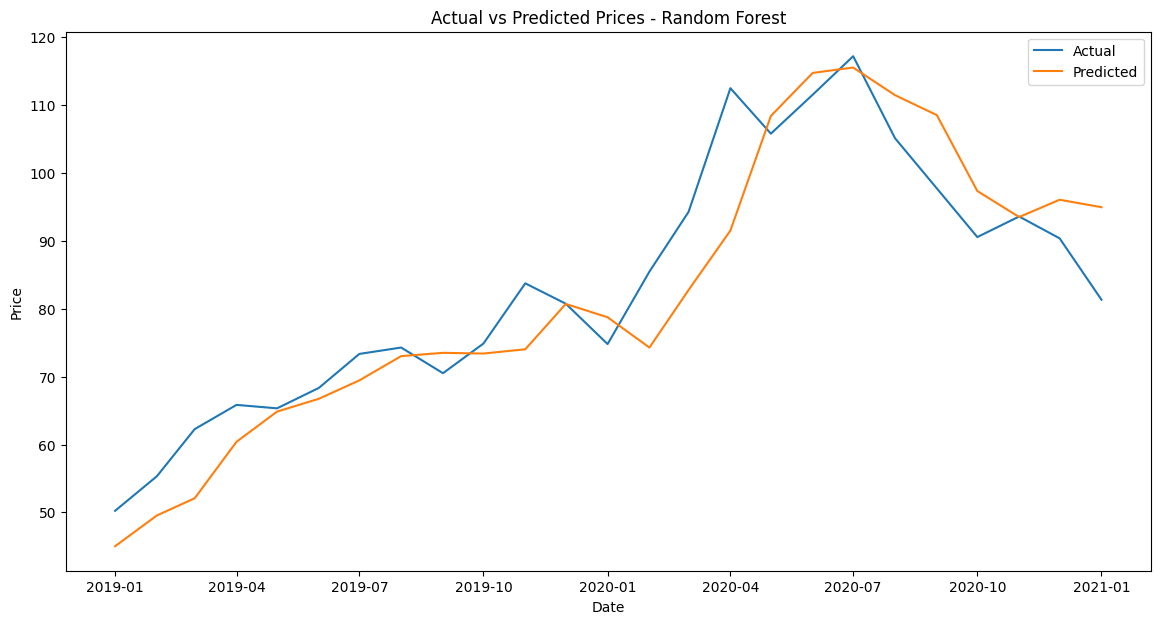

In [13]:
#%%

# Plot the actual vs predicted prices with plotly
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=test.index, y=test_data_timesteps[:,[timesteps-1]].flatten(), mode='lines', name='Actual'))
# fig.add_trace(go.Scatter(x=test.index, y=rf_predictions, mode='lines', name='Predicted'))
# fig.update_layout(title='Actual vs Predicted Prices - Random Forest',
#                   xaxis_title='Date',
#                   yaxis_title='Price')
# fig.show()

# plot with matplotlib
# Get the length of your predictions
pred_length = len(rf_predictions)

# Create a new figure
plt.figure(figsize=(14, 7))

# Plot the actual prices
plt.plot(test.index[:pred_length], test_data_timesteps[:pred_length, [timesteps-1]].flatten(), label='Actual')

# Plot the predicted prices
plt.plot(test.index[:pred_length], rf_predictions, label='Predicted')

# Set the title and labels
plt.title('Actual vs Predicted Prices - Random Forest')
plt.xlabel('Date')
plt.ylabel('Price')

# Add a legend
plt.legend(loc='best')

# Display the plot
plt.show()

14. **Forecasting Future Prices**: The model is used to forecast prices for the next 24 months. The forecasted prices are then plotted along with the historical data.


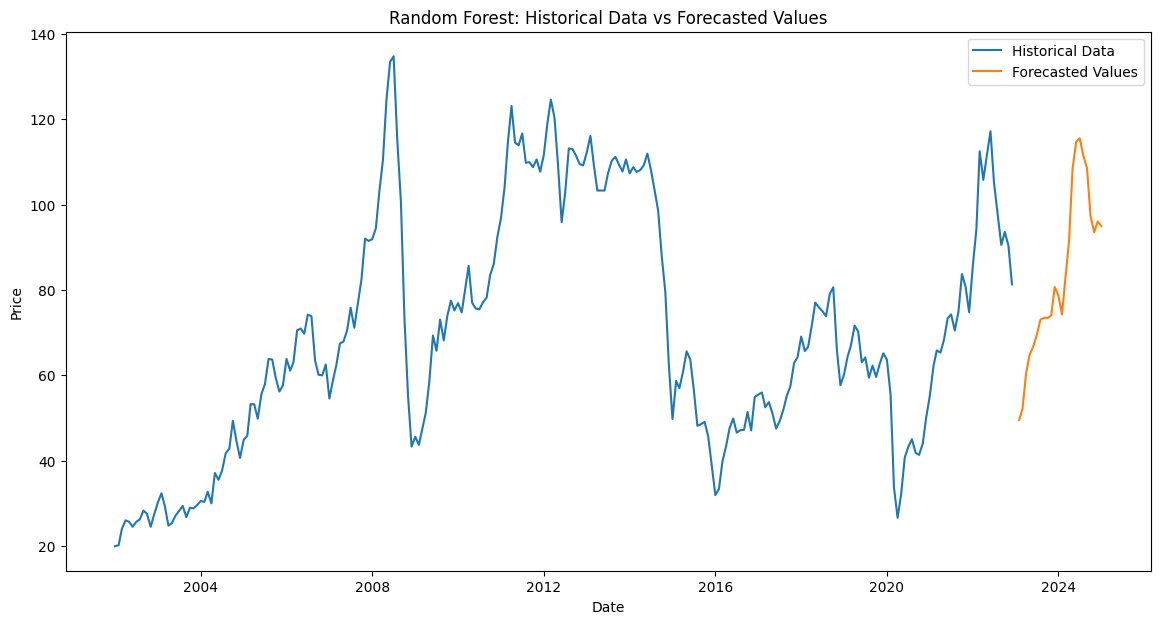

In [14]:
#%%

future_dates = pd.date_range(start=data.index[-1], periods=25, freq='M')[1:] # Start from the last date in the data and generate the next 24 months

# Make predictions on the future data
rf_forecast = best_rf.predict(test_data_timesteps[-24:,:timesteps-1])

# Plot the historical data and the forecasted data for each model individually
# fig_rf = go.Figure()
# fig_rf.add_trace(go.Scatter(x=data.index, y=data['Price'], mode='lines', name='Historical Data'))
# fig_rf.add_trace(go.Scatter(x=future_dates, y=rf_forecast, mode='lines', name='Forecasted Values'))
# fig_rf.update_layout(title='Random Forest: Historical Data vs Forecasted Values')
# fig_rf.show()

# plot with matplotlib

# import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Price'], label='Historical Data')
plt.plot(future_dates, rf_forecast, label='Forecasted Values')
plt.title('Random Forest: Historical Data vs Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()